# E

In [91]:
import argparse
import torch
import torch.nn as nn
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from exp.exp_imputation import Exp_Imputation
from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
from exp.exp_long_term_forecasting_partial import Exp_Long_Term_Forecast_Partial
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_classification import Exp_Classification
from utils.print_args import print_args
import random
import numpy as np
import time

In [15]:
# fix random seed
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
parser = argparse.ArgumentParser(description='TimesNet')

In [16]:
# config 지정 -> 오류 방지를 위해 

# basic config
parser.add_argument('--task_name', type=str, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--is_training', type=int, default=1, help='status')
parser.add_argument('--model_id', type=str, default='test', help='model id')
parser.add_argument('--model', type=str, default='Autoformer',
                    help='model name, options: [Autoformer, Transformer, TimesNet]')

# data loader
parser.add_argument('--data', type=str, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# added option 
parser.add_argument('--train_ratio', type=float, default=0.7, help='train data ratio')
parser.add_argument('--test_ratio', type=float, default=0.2, help='test data ratio')
parser.add_argument('--train_step', type=float, default=1.0, help='train data with certain stes. for example train_step=2 means only train even number of data')

# SparseTSF
parser.add_argument('--period_len', type=int, default=24, help='period length')

# PITS
parser.add_argument('--fc_dropout', type=float, default=0.05, help='fully connected dropout')
parser.add_argument('--head_dropout', type=float, default=0.0, help='head dropout')
parser.add_argument('--patch_len', type=int, default=16, help='patch length')
parser.add_argument('--stride', type=int, default=8, help='stride')
parser.add_argument('--shared_embedding', type=int, default=1, help='stride')
parser.add_argument('--padding_patch', default='end', help='None: None; end: padding on the end')
parser.add_argument('--revin', type=int, default=1, help='RevIN; True 1 False 0')
parser.add_argument('--affine', type=int, default=0, help='RevIN-affine; True 1 False 0')
parser.add_argument('--subtract_last', type=int, default=0, help='0: subtract mean; 1: subtract last')
parser.add_argument('--decomposition', type=int, default=0, help='decomposition; True 1 False 0')
parser.add_argument('--kernel_size', type=int, default=25, help='decomposition-kernel')
parser.add_argument('--individual', type=int, default=0, help='individual head; True 1 False 0')

# Piformer
parser.add_argument('--joint_var', type=int, default=0, help='use attention for each patching; True 1 False 0')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

# inputation task
parser.add_argument('--mask_rate', type=float, default=0.25, help='mask ratio')

# anomaly detection task
parser.add_argument('--anomaly_ratio', type=float, default=0.25, help='prior anomaly ratio (%)')

# model define
parser.add_argument('--expand', type=int, default=2, help='expansion factor for Mamba')
parser.add_argument('--d_conv', type=int, default=4, help='conv kernel size for Mamba')
parser.add_argument('--top_k', type=int, default=5, help='for TimesBlock')
parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--channel_independence', type=int, default=1,
                    help='0: channel dependence 1: channel independence for FreTS model')
parser.add_argument('--decomp_method', type=str, default='moving_avg',
                    help='method of series decompsition, only support moving_avg or dft_decomp')
parser.add_argument('--use_norm', type=int, default=1, help='whether to use normalize; True 1 False 0')
parser.add_argument('--down_sampling_layers', type=int, default=0, help='num of down sampling layers')
parser.add_argument('--down_sampling_window', type=int, default=1, help='down sampling window size')
parser.add_argument('--down_sampling_method', type=str, default=None,
                    help='down sampling method, only support avg, max, conv')
parser.add_argument('--seg_len', type=int, default=48,
                    help='the length of segmen-wise iteration of SegRNN')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# de-stationary projector params
parser.add_argument('--p_hidden_dims', type=int, nargs='+', default=[128, 128],
                    help='hidden layer dimensions of projector (List)')
parser.add_argument('--p_hidden_layers', type=int, default=2, help='number of hidden layers in projector')

# metrics (dtw)
parser.add_argument('--use_dtw', type=bool, default=False, 
                    help='the controller of using dtw metric (dtw is time consuming, not suggested unless necessary)')

# Augmentation
parser.add_argument('--augmentation_ratio', type=int, default=0, help="How many times to augment")
parser.add_argument('--seed', type=int, default=2, help="Randomization seed")
parser.add_argument('--jitter', default=False, action="store_true", help="Jitter preset augmentation")
parser.add_argument('--scaling', default=False, action="store_true", help="Scaling preset augmentation")
parser.add_argument('--permutation', default=False, action="store_true", help="Equal Length Permutation preset augmentation")
parser.add_argument('--randompermutation', default=False, action="store_true", help="Random Length Permutation preset augmentation")
parser.add_argument('--magwarp', default=False, action="store_true", help="Magnitude warp preset augmentation")
parser.add_argument('--timewarp', default=False, action="store_true", help="Time warp preset augmentation")
parser.add_argument('--windowslice', default=False, action="store_true", help="Window slice preset augmentation")
parser.add_argument('--windowwarp', default=False, action="store_true", help="Window warp preset augmentation")
parser.add_argument('--rotation', default=False, action="store_true", help="Rotation preset augmentation")
parser.add_argument('--spawner', default=False, action="store_true", help="SPAWNER preset augmentation")
parser.add_argument('--dtwwarp', default=False, action="store_true", help="DTW warp preset augmentation")
parser.add_argument('--shapedtwwarp', default=False, action="store_true", help="Shape DTW warp preset augmentation")
parser.add_argument('--wdba', default=False, action="store_true", help="Weighted DBA preset augmentation")
parser.add_argument('--discdtw', default=False, action="store_true", help="Discrimitive DTW warp preset augmentation")
parser.add_argument('--discsdtw', default=False, action="store_true", help="Discrimitive shapeDTW warp preset augmentation")
parser.add_argument('--extra_tag', type=str, default="", help="Anything extra")

_StoreAction(option_strings=['--extra_tag'], dest='extra_tag', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help='Anything extra', metavar=None)

In [17]:
# argument_text로 parser의 argument 지정 - 반드시 불러오는 모델과 동일하게 지정해야 함.

parse_seq = """--task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/weather/ \
  --data_path weather.csv \
  --model_id weather_24_24 \
  --model iTransformer \
  --data custom \
  --features MS \
  --seq_len 24 \
  --label_len 12 \
  --pred_len 24 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 21 \
  --dec_in 21 \
  --c_out 21 \
  --des 'Exp' \
  --d_model 64\
  --d_ff 64\
  --itr 1"""
args = parser.parse_args(parse_seq.split())
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

print('Args in experiment:')
print(args)

Args in experiment:
Namespace(activation='gelu', affine=0, anomaly_ratio=0.25, augmentation_ratio=0, batch_size=32, c_out=21, channel_independence=1, checkpoints='./checkpoints/', d_conv=4, d_ff=64, d_layers=1, d_model=64, data='custom', data_path='weather.csv', dec_in=21, decomp_method='moving_avg', decomposition=0, des="'Exp'", devices='0,1,2,3', discdtw=False, discsdtw=False, distil=True, down_sampling_layers=0, down_sampling_method=None, down_sampling_window=1, dropout=0.1, dtwwarp=False, e_layers=2, embed='timeF', enc_in=21, expand=2, extra_tag='', factor=3, fc_dropout=0.05, features='MS', freq='h', gpu=0, head_dropout=0.0, individual=0, inverse=False, is_training=1, itr=1, jitter=False, joint_var=0, kernel_size=25, label_len=12, learning_rate=0.0001, loss='MSE', lradj='type1', magwarp=False, mask_rate=0.25, model='iTransformer', model_id='weather_24_24_ts', moving_avg=25, n_heads=8, num_kernels=6, num_workers=10, output_attention=False, p_hidden_dims=[128, 128], p_hidden_layers=2

In [18]:
exp_model = Exp_Long_Term_Forecast(args)

Use GPU: cuda:0


In [19]:
# arguments 바탕으로 모델 생성
exp_model._build_model()

Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=24, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (value_projection): Linear(in_features=64, out_features=64, bias=True)
          (out_projection): Linear(in_features=64, out_features=64, bias=True)
        )
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
       

In [20]:
# 위의 argument와 맞는 모델 호출
checkpoint_path = './checkpoints/'
setting_path = 'long_term_forecast_weather_24_24_ts_iTransformer_custom_ftMS_sl24_ll12_pl24_dm64_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0(1725085922)'
model_path = f"{checkpoint_path}{setting_path}/checkpoint.pth"
exp_model.model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [21]:
# weather 데이터 불러오기 -> 96단위로 절단하기

from data_provider.data_loader import Dataset_Custom

dataset_weather_24 = Dataset_Custom(args, './dataset/weather/',
                                    flag='train', size=(24, 12, 24),
                                    features='MS', data_path = 'weather.csv',
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=0.7, test_ratio=0.2)

In [22]:
# 모델 훈련셋 결과 확인하기
from data_provider.data_factory import data_provider
from torch.utils.data import DataLoader

args.seq_len=24 # 입력길이 재조정
args.pred_len=24 # 출력길이 재조정
# dataset_weather_24에서 loader 생성
dataset_weather_24_loader = DataLoader(
            dataset_weather_24,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)

In [23]:
# 측정 모드로 전환
exp_model.model.eval()

Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=24, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (value_projection): Linear(in_features=64, out_features=64, bias=True)
          (out_projection): Linear(in_features=64, out_features=64, bias=True)
        )
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
       

In [24]:
dataset_weather_24[0][0].shape

(24, 21)

In [25]:
trues_te_tr[0].shape

(1, 24, 21)

In [26]:
from utils.metrics import *

In [28]:
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr = []
trues_te_tr = []
origin_te_tr = []
origin_y_te_tr = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_loader):
    if i<1000:
        origin_te_tr.append(batch_x)
        origin_y_te_tr.append(batch_y)
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
    
        batch_x_mark = batch_x_mark.float().to(exp_model.device)
        batch_y_mark = batch_y_mark.float().to(exp_model.device)
    
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
        # encoder - decoder
    
        # use_amp도 사용하지 않음, 
        outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
        outputs = outputs[:, -args.pred_len:, :]
        batch_y = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()
    
        pred = outputs
        true = batch_y
    
        preds_te_tr.append(pred)
        trues_te_tr.append(true)

origin_te_tr = np.concatenate(origin_te_tr, axis=0)
origin_y_te_tr = np.concatenate(origin_y_te_tr, axis=0)
preds_te_tr = np.concatenate(preds_te_tr, axis=0)
trues_te_tr = np.concatenate(trues_te_tr, axis=0)

In [29]:
MAE(origin_te_tr[24], origin_y_te_tr[:,12:,:][0])

0.0

In [30]:
MSE(origin_y_te_tr[:,12:,:][0], trues_te_tr[0]) # 역시 동일

9.68093686684049e-16

In [31]:
MSE(preds_te_tr, trues_te_tr)

0.13481076

In [32]:
# 24-> 24로 결과 generation 방법
# 첫번째 합성 데이터 사용
# preds_te_tr에서 
preds_m1_tr = [] # 1단계 합성
preds_m2_tr = [] # 2단계 합성
preds_m3_tr = [] # 3단계 합성
preds_m4_tr = [] # 4단계 합성

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_loader):

    if i>=24 and i<1000:
        batch_x1 = torch.Tensor([preds_te_tr[i-24]]).to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
    
        batch_x_mark = batch_x_mark.float().to(exp_model.device)
        batch_y_mark = batch_y_mark.float().to(exp_model.device)
    
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
        # encoder - decoder
    
        # use_amp도 사용하지 않음, 
        outputs1 = exp_model.model(batch_x1, batch_x_mark, dec_inp, batch_y_mark)
    
        outputs1 = outputs1[:, -args.pred_len:, :]
        outputs1 = outputs1.detach().cpu().numpy()
    
        preds_m1_tr.append(outputs1)

    if i>=48 and i<1000:
        batch_x2 = torch.Tensor(preds_m1_tr[i-48]).to(exp_model.device)

        # use_amp도 사용하지 않음, 
        outputs2 = exp_model.model(batch_x2, batch_x_mark, dec_inp, batch_y_mark)
        outputs2 = outputs2[:, -args.pred_len:, :]
        outputs2 = outputs2.detach().cpu().numpy()
    
        preds_m2_tr.append(outputs2)
    
    if i>=72 and i<1000:
        batch_x3 = torch.Tensor(preds_m2_tr[i-72]).to(exp_model.device)

        # use_amp도 사용하지 않음, 
        outputs3 = exp_model.model(batch_x3, batch_x_mark, dec_inp, batch_y_mark)
        outputs3 = outputs3[:, -args.pred_len:, :]
        outputs3 = outputs3.detach().cpu().numpy()
    
        preds_m3_tr.append(outputs3)

    if i>=96 and i<1000:
        batch_x4 = torch.Tensor(preds_m3_tr[i-96]).to(exp_model.device)

        # use_amp도 사용하지 않음, 
        outputs4 = exp_model.model(batch_x4, batch_x_mark, dec_inp, batch_y_mark)
        outputs4 = outputs4[:, -args.pred_len:, :]
        outputs4 = outputs4.detach().cpu().numpy()
    
        preds_m4_tr.append(outputs4)

preds_m1_tr = np.concatenate(preds_m1_tr, axis=0)
preds_m2_tr = np.concatenate(preds_m2_tr, axis=0)
preds_m3_tr = np.concatenate(preds_m3_tr, axis=0)
preds_m4_tr = np.concatenate(preds_m4_tr, axis=0)

In [33]:
preds_te_tr.shape

(1000, 24, 21)

In [34]:
# LinearRegression 사용해서 오차 비교
from sklearn.linear_model import LinearRegression

In [35]:
# 24-24 MSE/MAE/ME/CORR/RATIO_IRR 정리 (96~999 스텝 부분)

MSE(preds_te_tr[96:1000, :, :], trues_te_tr[96:1000, :, :]), MAE(preds_te_tr[96:1000, :, :], trues_te_tr[96:1000, :, :]), SMAE(preds_te_tr[96:1000, :, :], trues_te_tr[96:1000, :, :]), REC_CORR(preds_te_tr[96:1000, :, :], trues_te_tr[96:1000, :, :]), RATIO_IRR(preds_te_tr[96:1000, :, :], trues_te_tr[96:1000, :, :], 3)

(0.13600048,
 0.16279037,
 -0.031951766,
 0.018171838173407485,
 0.07316248770894788)

In [36]:
# Linear Regression 이용해서 정리
# preds_te_tr, preds_m1_tr, preds_m2_tr, preds_m3_tr -> trues_te_tr 유도
lr = LinearRegression()
nX = np.array([preds_te_tr[96:1000, :, :].reshape(-1), preds_m1_tr[72:976, :, :].reshape(-1), preds_m2_tr[48:952, :, :].reshape(-1), preds_m3_tr[24:928, :, :].reshape(-1)])
ny = trues_te_tr[96:1000, :, :].reshape(-1)
reg1 = lr.fit(nX.T,ny)
print(reg1.coef_)


[0.67272794 0.02474096 0.06188482 0.16868775]


In [121]:
nX.shape, ny.shape

((4, 455616), (455616,))

In [137]:
# test_result
rcf = reg1.coef_
rcf = [0.96,reg1.coef_[1],reg1.coef_[2]/4,0]
print(MSE(rcf[0]*preds_te_tr[96:192, :, :] + rcf[1]*preds_m1_tr[72:168, :, :] + rcf[2]*preds_m2_tr[48:144, :, :] + rcf[3]*preds_te_tr[24:120, :, :], trues_te_tr[96:192, :, :]))
print(MAE(rcf[0]*preds_te_tr[96:192, :, :] + rcf[1]*preds_m1_tr[72:168, :, :] + rcf[2]*preds_m2_tr[48:144, :, :] + rcf[3]*preds_te_tr[24:120, :, :], trues_te_tr[96:192, :, :]))

0.12872025
0.19829576


In [37]:
# LinearRegression 이용해서 최적화된 계수 비교하기
# 96-> 24 데이터와 정확도 비교

In [38]:
args.seq_len = 96 
exp_model2 = Exp_Long_Term_Forecast(args)

Use GPU: cuda:0


In [39]:
setting_path2 = 'long_term_forecast_weather_24_24_ts_iTransformer_custom_ftMS_sl96_ll12_pl24_dm64_nh8_el2_dl1_df64_expand2_dc4_fc3_ebtimeF_dtTrue_Exp_0(1725123684)'
model_path2 = f"{checkpoint_path}{setting_path2}/checkpoint.pth"
exp_model2.model.load_state_dict(torch.load(model_path2))

<All keys matched successfully>

In [40]:
# 측정 모드로 전환
exp_model2.model.eval()

Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (value_projection): Linear(in_features=64, out_features=64, bias=True)
          (out_projection): Linear(in_features=64, out_features=64, bias=True)
        )
        (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
       

In [41]:
dataset_weather_96_24 = Dataset_Custom(args, './dataset/weather/',
                                    flag='train', size=(96, 12, 24),
                                    features='MS', data_path = 'weather.csv',
                                    target='OT', scale=True, freq='h', timeenc=0,
                                    seasonal_patterns=None, train_ratio=0.7, test_ratio=0.2)
dataset_weather_96_24_loader = DataLoader(
            dataset_weather_96_24,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)

In [42]:
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr96 = []
trues_te_tr96 = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_96_24_loader):

    if i<928:
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
    
        batch_x_mark = batch_x_mark.float().to(exp_model.device)
        batch_y_mark = batch_y_mark.float().to(exp_model.device)
    
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
        # encoder - decoder
    
        # use_amp도 사용하지 않음, 
        outputs = exp_model2.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
        outputs = outputs[:, -args.pred_len:, :]
        batch_y = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()
    
        pred = outputs
        true = batch_y
    
        preds_te_tr96.append(pred)
        trues_te_tr96.append(true)

preds_te_tr96 = np.concatenate(preds_te_tr96, axis=0)
trues_te_tr96 = np.concatenate(trues_te_tr96, axis=0)

In [43]:
preds_te_tr96.shape

(928, 24, 21)

In [44]:
# 96 to 24
MSE(preds_te_tr96, trues_te_tr96), MAE(preds_te_tr96, trues_te_tr96)

(0.14120887, 0.2197242)

In [45]:
MSE(preds_te_tr96, preds_te_tr[72:]), MAE(preds_te_tr96, preds_te_tr[72:]), REC_CORR(preds_te_tr96, preds_te_tr[72:])

(0.076825835, 0.15383437, 0.18518099518682804)

In [46]:
# 24 to 24
MSE(preds_te_tr[72:], trues_te_tr[72:]), MAE(preds_te_tr[72:], trues_te_tr[72:])

(0.1371825, 0.16598748)

In [47]:
# 24 to 24 반복 확인
print(MSE(preds_m1_tr[48:], trues_te_tr[72:]), MAE(preds_m1_tr[48:], trues_te_tr[72:]))
print(MSE(preds_m2_tr[24:], trues_te_tr[72:]), MAE(preds_m2_tr[24:], trues_te_tr[72:]))
print(MSE(preds_m3_tr[0:], trues_te_tr[72:]), MAE(preds_m3_tr[0:], trues_te_tr[72:]))

0.21753576 0.25849262
0.25563183 0.29859507
0.265332 0.3086457


In [48]:
# 같은 거 확인
MSE(trues_te_tr[72:], trues_te_tr96)

0.0

In [49]:
%matplotlib inline

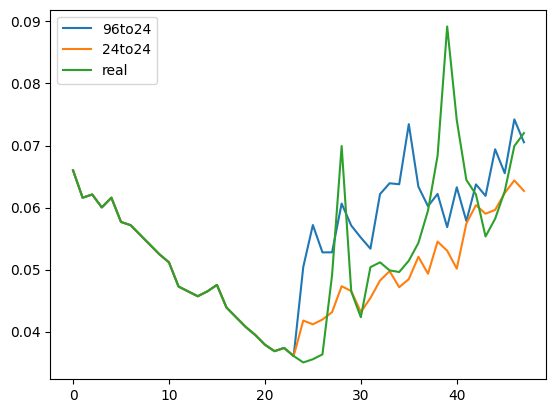

In [50]:
# 그래프 출력
import matplotlib.pyplot as plt

idx = 2
plt.plot(range(48), np.concatenate([trues_te_tr[idx+48, :, -1], preds_te_tr96[idx, :,-1]]), label='96to24' )
plt.plot(range(48), np.concatenate([trues_te_tr[idx+48, :, -1], preds_te_tr[idx+72, :,-1]]), label='24to24' )
plt.plot(range(48), np.concatenate([trues_te_tr[idx+48, :, -1], trues_te_tr[idx+72, :,-1]]), label='real' )
plt.legend()
plt.show()

In [169]:
# coefficient 확인하기

# np.save('preds_te_tr.npy', preds_te_tr[72:])
# np.save('preds_m1_tr.npy', preds_m1_tr[48:])
# np.save('preds_m2_tr.npy', preds_m2_tr[24:])
# np.save('preds_m3_tr.npy', preds_m3_tr[0:])
# np.save('preds_te_tr96.npy', preds_te_tr96[0:])

In [57]:
# pred_te_tr96을 preds_te_tr, preds_m1_tr, preds_m2_tr, preds_m3_tr 관계식으로 유도

# 입력 데이터 준비
X = np.hstack([
    preds_te_tr[72:].reshape(-1, 1),   # 각 예측값을 2차원 배열로 변환
    preds_m1_tr[48:].reshape(-1, 1),
    preds_m2_tr[24:].reshape(-1, 1),
    preds_m3_tr.reshape(-1, 1)
])

# 목표 변수 trues_te_tr96 준비
y = trues_te_tr96.reshape(-1, 1)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X, y)

# 예측값 생성
y_pred = model.predict(X)

# 학습된 계수 확인
coefficients = model.coef_

mae = MAE(y, y_pred)
mse = MSE(y, y_pred)
me = SMAE(y_pred, y)
corr = REC_CORR(y, y_pred)
irr = RATIO_IRR(y, y_pred, 3)


print(f"선형 회귀 계수: {coefficients}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"ME: {me}")
print(f"IRR(3): {irr}")
print(f"CORR: {corr}")

선형 회귀 계수: [[0.6694057  0.01228346 0.08229496 0.16961703]]
MAE: 0.18461628258228302
MSE: 0.1155468001961708
ME: -2.0423285604920238e-05
IRR(3): 0.05272475369458128
CORR: nan


In [109]:
# 이제 coef를 찾았으니 실제 데이터와 비교하기
# 우선 실제 예측값
print('96/24 model test result (MSE, MAE, SMAE, corr)')
print(MSE(preds_te_tr96, trues_te_tr96), MAE(preds_te_tr96, trues_te_tr96), SMAE(preds_te_tr96, trues_te_tr96), REC_CORR(preds_te_tr96, trues_te_tr96))
# 그리고 변형된 예측값
preds_combi_tr = y_pred.reshape(928, 24, 21)
print('linear combination of 24/24 model test result (MSE, MAE, SMAE, corr)')
print(MSE(preds_combi_tr, trues_te_tr96), MAE(preds_combi_tr, trues_te_tr96), SMAE(preds_combi_tr, trues_te_tr96), REC_CORR(preds_combi_tr, trues_te_tr96))

96/24 model test result (MSE, MAE, SMAE, corr)
0.14120887 0.2197242 -0.052614972 0.05851074624644418
linear combination of 24/24 model test result (MSE, MAE, SMAE, corr)
0.1155468 0.18461628 -2.0423286e-05 0.009536485189151329


In [108]:
print(MSE(preds_combi_tr, preds_te_tr96), MAE(preds_combi_tr, preds_te_tr96), SMAE(preds_combi_tr, preds_te_tr96), REC_CORR(preds_combi_tr, preds_te_tr96))

0.047254257 0.12507825 0.052594554 0.1744879791222337


In [79]:
from layers.Autoformer_EncDec import series_decomp, moving_avg

In [71]:
args.seq_len = 24
decomp = series_decomp(args.moving_avg)

In [72]:
preds_combi_tr[j:j+1].shape

(1, 24, 21)

In [83]:
# batch_8로 처리
preds_combi_s_tr = []
preds_combi_t_tr = []
for j in range(0, 928):
    s_enc, t_enc = decomp(torch.Tensor(preds_combi_tr[j:j+1]))
    preds_combi_s_tr.append(s_enc)
    preds_combi_t_tr.append(t_enc)

preds_combi_s_tr = np.concatenate(preds_combi_s_tr, axis=0)
preds_combi_t_tr = np.concatenate(preds_combi_t_tr, axis=0)

In [93]:
preds_combi_s_tr.shape, preds_combi_t_tr.shape

((928, 24, 21), (928, 24, 21))

In [87]:
preds_te_s_tr = []
preds_te_t_tr = []
for j in range(0, 928):
    s_enc, t_enc = decomp(torch.Tensor(preds_te_tr[j:j+1]))
    preds_te_s_tr.append(s_enc)
    preds_te_t_tr.append(t_enc)

preds_te_s_tr = np.concatenate(preds_te_s_tr, axis=0)
preds_te_t_tr = np.concatenate(preds_te_t_tr, axis=0)

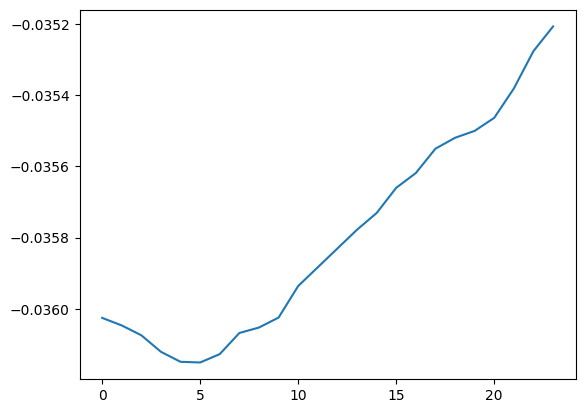

In [99]:
idx0 = 432
plt.plot(range(24), preds_combi_t_tr[idx0, :, -1])

In [100]:
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_combi_s_tr_res = []
preds_combi_t_tr_res = []
preds_te_s_tr_res = []
preds_te_t_tr_res = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_loader):

    if i<928:
        # batch_x = batch_x.float().to(exp_model.device)
        preds_combi_s = torch.Tensor(preds_combi_s_tr[i:i+1]).float().to(exp_model.device)
        preds_combi_t = torch.Tensor(preds_combi_t_tr[i:i+1]).float().to(exp_model.device)
        preds_te_s = torch.Tensor(preds_te_s_tr[i:i+1]).float().to(exp_model.device)
        preds_te_t = torch.Tensor(preds_te_t_tr[i:i+1]).float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
    
        batch_x_mark = batch_x_mark.float().to(exp_model.device)
        batch_y_mark = batch_y_mark.float().to(exp_model.device)
    
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
        # encoder - decoder
    
        # use_amp도 사용하지 않음, 
        outputs_cs = exp_model.model(preds_combi_s, batch_x_mark, dec_inp, batch_y_mark)
        outputs_cs = outputs_cs[:, -args.pred_len:, :]
        outputs_cs = outputs_cs.detach().cpu().numpy()

        outputs_ct = exp_model.model(preds_combi_t, batch_x_mark, dec_inp, batch_y_mark)
        outputs_ct = outputs_ct[:, -args.pred_len:, :]
        outputs_ct = outputs_ct.detach().cpu().numpy()

        outputs_ts = exp_model.model(preds_te_s, batch_x_mark, dec_inp, batch_y_mark)
        outputs_ts = outputs_ts[:, -args.pred_len:, :]
        outputs_ts = outputs_ts.detach().cpu().numpy()

        outputs_tt = exp_model.model(preds_te_t, batch_x_mark, dec_inp, batch_y_mark)
        outputs_tt = outputs_tt[:, -args.pred_len:, :]
        outputs_tt = outputs_tt.detach().cpu().numpy()
    
        preds_combi_s_tr_res.append(outputs_cs)
        preds_combi_t_tr_res.append(outputs_ct)
        preds_te_s_tr_res.append(outputs_ts)
        preds_te_t_tr_res.append(outputs_tt)

preds_combi_s_tr_res = np.concatenate(preds_combi_s_tr_res, axis=0)
preds_combi_t_tr_res = np.concatenate(preds_combi_t_tr_res, axis=0)
preds_te_s_tr_res = np.concatenate(preds_te_s_tr_res, axis=0)
preds_te_t_tr_res = np.concatenate(preds_te_t_tr_res, axis=0)

In [103]:
preds_combi_s_tr_res.shape

(928, 24, 21)

In [110]:
MAE(preds_combi_s_tr[0,2:,:], preds_combi_s_tr[2,:22, :]), MSE(preds_combi_s_tr[0,2:,:], preds_combi_s_tr[2,:22, :])

(0.021759063, 0.0014769618)

In [112]:
# train_data 전체에 대해서도 series_decomp 적용가능한가?

import pandas as pd
from sklearn.preprocessing import StandardScaler

df_weather = pd.read_csv('./dataset/weather/weather.csv')
df_weather = df_weather.drop(columns=['date'])

df_weather

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
0,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
1,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,...,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
3,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,...,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
4,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,...,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52691,978.32,2.28,277.16,-0.80,80.0,7.20,5.76,1.44,3.67,5.89,...,0.73,1.40,180.6,0.0,0.0,0.0,0.0,0.0,13.40,433.0
52692,978.30,2.13,277.01,-0.43,83.1,7.12,5.92,1.20,3.77,6.05,...,0.43,0.82,174.0,0.0,0.0,0.0,0.0,0.0,13.42,439.6
52693,978.26,1.99,276.88,-0.71,82.2,7.05,5.80,1.26,3.69,5.93,...,0.38,0.76,248.9,0.0,0.0,0.0,0.0,0.0,13.45,435.2
52694,978.26,2.07,276.95,-0.77,81.4,7.09,5.77,1.32,3.68,5.90,...,0.57,1.07,196.6,0.0,0.0,0.0,0.0,0.0,13.47,433.9


In [114]:
num_total = len(df_weather)
num_train = int(num_total * 0.7)
num_test = int(num_total * 0.2)
num_vali = num_total - num_train - num_test
border1s = [0, num_train - 24, num_total - num_test - 24]
border2s = [num_train, num_train + num_vali, num_total]

In [115]:
# weather_df에서 train data 얻기
scaler = StandardScaler()
train_data = df_weather[border1s[0]:border2s[0]]
scaler.fit(train_data.values)
df_data = scaler.transform(df_weather.values)

In [117]:
df_data.shape

(52696, 21)

In [120]:
torch.Tensor(df_data).reshape(1, df_data.shape[0], df_data.shape[1])

tensor([[[ 2.1143, -1.4600, -1.6079,  ..., -0.5883, -1.4241,  0.0444],
         [ 2.0992, -1.4548, -1.6029,  ..., -0.5883, -1.4166,  0.0441],
         [ 2.0876, -1.4574, -1.6041,  ..., -0.5883, -1.4053,  0.0431],
         ...,
         [-1.4347, -1.2941, -1.1406,  ..., -0.5883, -1.1734,  0.0629],
         [-1.4347, -1.2838, -1.1317,  ..., -0.5883, -1.1709,  0.0595],
         [-1.4370, -1.2916, -1.1393,  ..., -0.5883, -1.1697,  0.0663]]])

In [123]:
# 전체에서도 series_decomp 시전 가능?

df_data_s , df_data_t = decomp(torch.Tensor(df_data).reshape(1, df_data.shape[0], df_data.shape[1]))

In [126]:
df_data_s.shape, df_data_t.shape

(torch.Size([1, 52696, 21]), torch.Size([1, 52696, 21]))

In [127]:
df_data_s

tensor([[[ 2.4610e-02,  3.0058e-02,  2.7436e-02,  ...,  1.1921e-07,
          -2.9180e-02, -4.3651e-03],
         [ 1.2050e-02,  3.9749e-02,  3.6682e-02,  ...,  1.1921e-07,
          -2.4718e-02, -5.2089e-03],
         [ 3.1977e-03,  4.1977e-02,  3.9865e-02,  ...,  1.1921e-07,
          -1.6245e-02, -6.7820e-03],
         ...,
         [-1.1123e-03, -1.9331e-02, -1.7836e-02,  ...,  1.1921e-07,
           5.0116e-04,  1.7710e-03],
         [-1.5293e-03, -7.0482e-03, -7.0739e-03,  ...,  1.1921e-07,
           2.6568e-03, -2.1252e-03],
         [-3.9856e-03, -1.3112e-02, -1.2935e-02,  ...,  1.1921e-07,
           3.7098e-03,  4.1775e-03]]])

In [133]:
# series_decomp 이용해서 데이터 저장
np.savez('./dataset/weather/weather_decomp_s.npz', data=df_data_s.reshape(df_data.shape[0], df_data.shape[1], 1))
np.savez('./dataset/weather/weather_decomp_t.npz', data=df_data_t.reshape(df_data.shape[0], df_data.shape[1], 1))

In [134]:
from data_provider.data_loader import Dataset_PEMS

# 데이터 불러오기 - seasonal, trend 부분 분리
dataset_weather_24_s = Dataset_PEMS('./dataset/weather/', flag='train', size=(24,12,24),
                                    features='M', data_path='weather_decomp_s.npz',
                                    target='OT', scale=False, timeenc=0, freq='h',
                                    seasonal_patterns=None, train_ratio=0.7, test_ratio=0.2)
dataset_weather_24_t = Dataset_PEMS('./dataset/weather/', flag='train', size=(24,12,24),
                                    features='M', data_path='weather_decomp_t.npz',
                                    target='OT', scale=False, timeenc=0, freq='h',
                                    seasonal_patterns=None, train_ratio=0.7, test_ratio=0.2)

In [140]:
dataset_weather_24_s_loader = DataLoader(
            dataset_weather_24_s,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)
dataset_weather_24_t_loader = DataLoader(
            dataset_weather_24_t,
            batch_size=1, # 모든 데이터셋을 확인해야 해서 batch_size를 강제로 1로 조정.
            shuffle=False,
            num_workers=args.num_workers,
            drop_last=False)

In [ ]:
# 실험

In [141]:
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr_s = []
trues_te_tr_s = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_s_loader):
    if i<1000:
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
    
        batch_x_mark = batch_x_mark.float().to(exp_model.device)
        batch_y_mark = batch_y_mark.float().to(exp_model.device)
    
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
        # encoder - decoder
    
        # use_amp도 사용하지 않음, 
        outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
        outputs = outputs[:, -args.pred_len:, :]
        batch_y = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()
    
        pred = outputs
        true = batch_y
    
        preds_te_tr_s.append(pred)
        trues_te_tr_s.append(true)

preds_te_tr_s = np.concatenate(preds_te_tr_s, axis=0)
trues_te_tr_s = np.concatenate(trues_te_tr_s, axis=0)

In [142]:
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr_t = []
trues_te_tr_t = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_t_loader):
    if i<1000:
        batch_x = batch_x.float().to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
    
        batch_x_mark = batch_x_mark.float().to(exp_model.device)
        batch_y_mark = batch_y_mark.float().to(exp_model.device)
    
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
        # encoder - decoder
    
        # use_amp도 사용하지 않음, 
        outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
        outputs = outputs[:, -args.pred_len:, :]
        batch_y = batch_y[:, -args.pred_len:, :].to(exp_model.device)
        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()
    
        pred = outputs
        true = batch_y
    
        preds_te_tr_t.append(pred)
        trues_te_tr_t.append(true)

preds_te_tr_t = np.concatenate(preds_te_tr_t, axis=0)
trues_te_tr_t = np.concatenate(trues_te_tr_t, axis=0)

In [152]:
# 최종확인 - series_decomp를 s와 t에 대해 적용했을 때 오차 비교해보자
# 이제 coef를 찾았으니 실제 데이터와 비교하기
# 우선 실제 예측값
print('series_decomp_s 오차 확인 (MSE, MAE, SMAE, corr)')
print(MSE(preds_te_tr_s, trues_te_tr_s), MAE(preds_te_tr_s, trues_te_tr_s), SMAE(preds_te_tr_s, trues_te_tr_s), REC_CORR(preds_te_tr_s, trues_te_tr_s))
print('series_decomp_t 오차 확인 (MSE, MAE, SMAE, corr)')
print(MSE(preds_te_tr_t, trues_te_tr_t), MAE(preds_te_tr_t, trues_te_tr_t), SMAE(preds_te_tr_t, trues_te_tr_t), REC_CORR(preds_te_tr_t, trues_te_tr_t))
print('전체 오차 확인 (MSE, MAE, SMAE, corr)')
print(MSE(preds_te_tr, trues_te_tr), MAE(preds_te_tr, trues_te_tr), SMAE(preds_te_tr, trues_te_tr), REC_CORR(preds_te_tr, trues_te_tr))
print('합산 오차 확인 (MSE, MAE, SMAE, corr)')
print(MSE(preds_te_tr_s+preds_te_tr_t, trues_te_tr), MAE(preds_te_tr_s+preds_te_tr_t, trues_te_tr), SMAE(preds_te_tr_s+preds_te_tr_t, trues_te_tr), REC_CORR(preds_te_tr_s+preds_te_tr_t, trues_te_tr))
                                                                                                             

series_decomp_s 오차 확인 (MSE, MAE, SMAE, corr)
0.07066208 0.086639486 -0.036809407 0.01073519387526788
series_decomp_t 오차 확인 (MSE, MAE, SMAE, corr)
0.050169557 0.12502716 -0.026788756 -0.06609249888945866
전체 오차 확인 (MSE, MAE, SMAE, corr)
0.13481076 0.1680959 -0.0348973 0.019515970143010583
합산 오차 확인 (MSE, MAE, SMAE, corr)
0.15021664 0.17654504 -0.06359816 0.03997723752568284


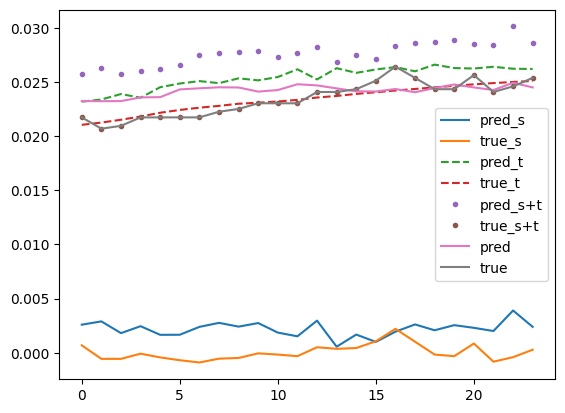

In [149]:
# 그래프로 그려보기

idx0 = 433
val = -1
plt.plot(range(24), preds_te_tr_s[idx0, :, val], label='pred_s')
plt.plot(range(24), trues_te_tr_s[idx0, :, val], label='true_s')
plt.plot(range(24), preds_te_tr_t[idx0, :, val], '--', label='pred_t')
plt.plot(range(24), trues_te_tr_t[idx0, :, val], '--', label='true_t')
plt.plot(range(24), preds_te_tr_s[idx0, :, val] + preds_te_tr_t[idx0, :, val], '.', label='pred_s+t')
plt.plot(range(24), trues_te_tr_s[idx0, :, val] + trues_te_tr_t[idx0, :, val], '.', label='true_s+t')
plt.plot(range(24), preds_te_tr[idx0, :, val], label='pred')
plt.plot(range(24), trues_te_tr[idx0, :, val], label='true')
plt.legend()
plt.show()

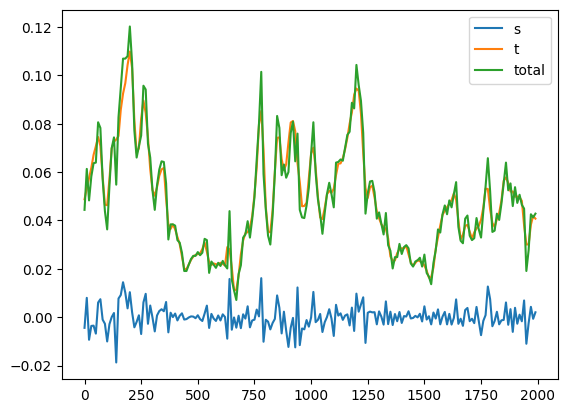

In [155]:
# 참고 - 20 간격으로 전체 분포 그리기
var_0 = -1
plt.plot(range(0, 2000, 10), df_data_s[0,:2000:10, var_0], label='s')
plt.plot(range(0, 2000, 10), df_data_t[0,:2000:10, var_0], label='t')
plt.plot(range(0, 2000, 10), df_data_s[0,:2000:10, var_0]+df_data_t[0,:2000:10, var_0], label='total')
plt.legend()
plt.show()

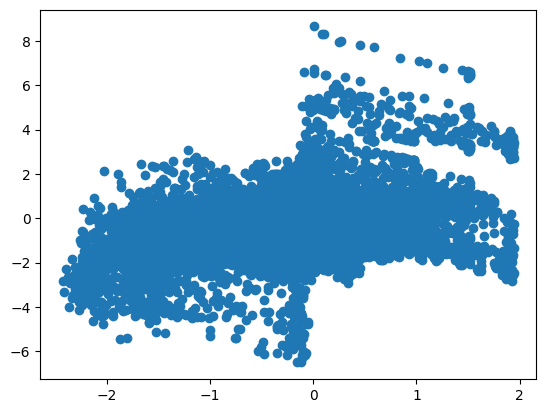

[[1.         0.23412284]
 [0.23412284 1.        ]]


In [159]:
# 마지막 확인 - seasonal 오차와 trend 오차는 방향이 거의 비슷해보임
plt.scatter((trues_te_tr_t - preds_te_tr_t), (trues_te_tr_s - preds_te_tr_s))
plt.show()
print(np.corrcoef((trues_te_tr_t - preds_te_tr_t).reshape(-1), (trues_te_tr_s - preds_te_tr_s).reshape(-1)))

In [ ]:
# 이제 전체 테스트로 다시 시도

# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr = []
trues_te_tr = []
origin_te_tr = []
origin_y_te_tr = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_loader):

    origin_te_tr.append(batch_x)
    origin_y_te_tr.append(batch_y)
    batch_x = batch_x.float().to(exp_model.device)
    batch_y = batch_y.float().to(exp_model.device)

    batch_x_mark = batch_x_mark.float().to(exp_model.device)
    batch_y_mark = batch_y_mark.float().to(exp_model.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(exp_model.device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred = outputs
    true = batch_y

    preds_te_tr.append(pred)
    trues_te_tr.append(true)

origin_te_tr = np.concatenate(origin_te_tr, axis=0)
origin_y_te_tr = np.concatenate(origin_y_te_tr, axis=0)
preds_te_tr = np.concatenate(preds_te_tr, axis=0)
trues_te_tr = np.concatenate(trues_te_tr, axis=0)

1

In [ ]:
# 24-> 24로 결과 generation 방법
# 첫번째 합성 데이터 사용
# preds_te_tr에서 
preds_m1_tr = [] # 1단계 합성
preds_m2_tr = [] # 2단계 합성
preds_m3_tr = [] # 3단계 합성
preds_m4_tr = [] # 4단계 합성

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_24_loader):

    if i>=24:
        batch_x1 = torch.Tensor([preds_te_tr[i-24]]).to(exp_model.device)
        batch_y = batch_y.float().to(exp_model.device)
    
        batch_x_mark = batch_x_mark.float().to(exp_model.device)
        batch_y_mark = batch_y_mark.float().to(exp_model.device)
    
        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
        # encoder - decoder
    
        # use_amp도 사용하지 않음, 
        outputs1 = exp_model.model(batch_x1, batch_x_mark, dec_inp, batch_y_mark)
    
        outputs1 = outputs1[:, -args.pred_len:, :]
        outputs1 = outputs1.detach().cpu().numpy()
    
        preds_m1_tr.append(outputs1)

    if i>=48:
        batch_x2 = torch.Tensor(preds_m1_tr[i-48]).to(exp_model.device)

        # use_amp도 사용하지 않음, 
        outputs2 = exp_model.model(batch_x2, batch_x_mark, dec_inp, batch_y_mark)
        outputs2 = outputs2[:, -args.pred_len:, :]
        outputs2 = outputs2.detach().cpu().numpy()
    
        preds_m2_tr.append(outputs2)
    
    if i>=72:
        batch_x3 = torch.Tensor(preds_m2_tr[i-72]).to(exp_model.device)

        # use_amp도 사용하지 않음, 
        outputs3 = exp_model.model(batch_x3, batch_x_mark, dec_inp, batch_y_mark)
        outputs3 = outputs3[:, -args.pred_len:, :]
        outputs3 = outputs3.detach().cpu().numpy()
    
        preds_m3_tr.append(outputs3)

    if i>=96:
        batch_x4 = torch.Tensor(preds_m3_tr[i-96]).to(exp_model.device)

        # use_amp도 사용하지 않음, 
        outputs4 = exp_model.model(batch_x4, batch_x_mark, dec_inp, batch_y_mark)
        outputs4 = outputs4[:, -args.pred_len:, :]
        outputs4 = outputs4.detach().cpu().numpy()
    
        preds_m4_tr.append(outputs4)

preds_m1_tr = np.concatenate(preds_m1_tr, axis=0)
preds_m2_tr = np.concatenate(preds_m2_tr, axis=0)
preds_m3_tr = np.concatenate(preds_m3_tr, axis=0)
preds_m4_tr = np.concatenate(preds_m4_tr, axis=0)

In [ ]:
# 트레인 데이터셋을 테스트해서 결과 받기, test 함수에서 가져옴
preds_te_tr96 = []
trues_te_tr96 = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(dataset_weather_96_24_loader):


    batch_x = batch_x.float().to(exp_model.device)
    batch_y = batch_y.float().to(exp_model.device)

    batch_x_mark = batch_x_mark.float().to(exp_model.device)
    batch_y_mark = batch_y_mark.float().to(exp_model.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp_model.device)
    # encoder - decoder

    # use_amp도 사용하지 않음, 
    outputs = exp_model2.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

    outputs = outputs[:, -args.pred_len:, :]
    batch_y = batch_y[:, -args.pred_len:, :].to(exp_model.device)
    outputs = outputs.detach().cpu().numpy()
    batch_y = batch_y.detach().cpu().numpy()

    pred = outputs
    true = batch_y

    preds_te_tr96.append(pred)
    trues_te_tr96.append(true)

preds_te_tr96 = np.concatenate(preds_te_tr96, axis=0)
trues_te_tr96 = np.concatenate(trues_te_tr96, axis=0)